<a href="https://colab.research.google.com/github/lee813/Protein/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, RepeatVector
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras import objectives

Using TensorFlow backend.


In [0]:
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 
    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.
    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_sigma) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.mse(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae, encoder, generator

In [0]:
import numpy as np
import matplotlib.pyplot as plt


def get_data():
    # read data from file
    # data = np.fromfile('sample_data.dat').reshape(419,13)
    data = np.load('CB513.npy')[1:50, 1:2000]
    
    timesteps = 3
    dataX = []
    for i in range(len(data) - timesteps - 1):
        x = data[i:(i+timesteps), :]
        dataX.append(x)
    return np.array(dataX)
    #return data

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
45/45 [==============================] - 7s 153ms/step - loss: 0.1049
Epoch 2/50
45/45 [==============================] - 2s 40ms/step - loss: 0.0976
Epoch 3/50
45/45 [==============================] - 2s 39ms/step - loss: 0.0957
Epoch 4/50
45/45 [==============================] - 2s 40ms/step - loss: 0.0963
Epoch 5/50
45/45 [==============================] - 2s 39ms/step - loss: 0.0923
Epoch 6/50
45/45 [==============================] - 2s 41ms/step - loss: 0.0921
Epoch 7/50
45/45 [==============================] - 2s 41ms/step - loss: 0.0875
Epoch 8/50
45/45 [==============================] - 2s 40ms/step - loss: 0.0859
Epoch 9/50
45/45 [==============================] - 2s 42ms/step - loss: 0.0867
Epoch 10/50
45/45 [==============================] - 2s 43ms/step - loss: 0.0835
Epoch 11/50
45/45 [==============================] - 2s 39ms/step - loss: 0.08

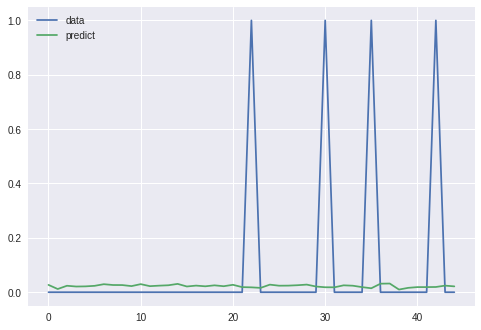

In [0]:
x = get_data()
input_dim = x.shape[-1] # 13
timesteps = x.shape[1] # 3
batch_size = 1

vae, enc, gen = create_lstm_vae(input_dim, 
    timesteps=timesteps, 
    batch_size=batch_size, 
    intermediate_dim=32,
    latent_dim=100,
    epsilon_std=1.)

vae.fit(x, x, epochs=50)

preds = vae.predict(x, batch_size=batch_size)

# pick a column to plot.
print("[plotting...]")
print("x: %s, preds: %s" % (x.shape, preds.shape))
plt.plot(x[:,0,3], label='data')
plt.plot(preds[:,0,3], label='predict')
plt.legend()
plt.show()

In [0]:
x[1,:]

array([[0.64931299, 0.89654163, 0.27325002, 0.22932992, 0.87211755,
        0.14258337, 0.28571429, 0.31818182, 0.96153846, 0.71568627,
        0.3442029 , 0.41489362, 0.25925926],
       [0.64931299, 0.89654163, 0.27325002, 0.22932992, 0.87211755,
        0.14258337, 0.35714286, 0.36931818, 1.        , 0.83333333,
        0.44927536, 0.50531915, 0.27777778],
       [0.64931299, 0.89654163, 0.27325002, 0.22932992, 0.87211755,
        0.14258337, 0.35714286, 0.47727273, 0.79230769, 0.92156863,
        0.50724638, 0.64893617, 0.27777778]])

In [0]:
cb513 = np.load('CB513.npy')

In [0]:
cb513.shape

(514, 39900)

In [0]:
cb513[3, 100:300]

array([0.21416502, 0.04697615, 0.0710943 , 0.09029814, 0.99941306,
       0.17653527, 0.08471057, 0.33181223, 0.22970105, 0.09449037,
       0.01945508, 0.11920292, 0.04148712, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.96007467,
       0.27888482, 0.1480472 , 0.22097389, 0.08706577, 0.86056613,
       0.12564786, 0.31431989, 0.24973989, 0.17653527, 0.25350602,
       0.22970105, 0.2042403 , 0.24048908, 0.14679034, 0.82635335,
       0.4875026 , 0.65248946, 0.05315114, 0.5       , 0.11405238,
       0.        , 0.        , 0.        , 0.        , 0.     

In [0]:
preds.shape

(45, 3, 1999)

In [0]:
preds[2,2, 1:100]

array([ 1.74937136e-02,  1.52654117e-02,  6.74365312e-02,  6.13621175e-02,
        4.70960364e-02,  9.01607145e-03,  1.58650745e-02,  1.30070716e-01,
        4.04332466e-02,  2.96830852e-02, -9.39975027e-03,  5.34684397e-02,
        1.30865410e-01,  6.56378791e-02,  8.77321362e-02,  7.21537974e-03,
        3.22074704e-02,  2.58962139e-02,  8.30399152e-03,  7.11623998e-03,
        9.65786159e-01,  7.56594772e-03,  3.47007141e-02, -4.44895960e-03,
       -1.04699822e-04,  2.41949931e-02,  8.77524614e-02,  1.33004049e-02,
        1.39392288e-02,  9.66556251e-01, -5.04179578e-03,  9.28535964e-03,
        2.09852564e-03,  3.76629144e-01,  9.09679383e-02,  1.28239155e-01,
        1.58330008e-01,  1.77292302e-01,  1.58161372e-01,  9.45109129e-02,
        2.41709590e-01,  2.38120213e-01,  2.72488564e-01,  3.03393215e-01,
        2.05817983e-01,  1.29895583e-01,  2.64738530e-01,  1.75369084e-01,
        3.98848146e-01,  2.71521658e-01,  2.58469671e-01,  5.75635023e-02,
        3.32379460e-01,  

In [0]:
Dataset
You can get training and test dataset from http://www.princeton.edu/~jzthree/datasets/ICML2014/. In the FTP directory, "cullpdb+profile_6133_filtered.npy.gz" is a training dataset and "cb513+profile_split1.npy.gz" is a test dataset. Download them and use them for your calculation. For description of the files, read "dataset_readme.txt" in the directory carefully.

The training dataset and test dataset includes 5534 and 514 (correctly 513) sequences respectively. So, if you want to shape it by "[sequence number] * [sequence] * [features]" format, write code as follow.

1
2
3
4
5
6
7
8
9
10
11
12
13
#!/usr/bin/env python3
import numpy as np
np.set_printoptions(threshold=np.inf,linewidth=np.inf)
 
def main():
    nptrain = np.load("cullpdb+profile_6133_filtered.npy")
    nptrain = np.reshape(nptrain,(5534,700,57))
     
    nptest = np.load("cb513+profile_split1.npy")
    nptest = np.reshape(nptest,(514,700,57))
     
if __name__ == '__main__':
    main()

    
    
    https://blog.csdn.net/u013841458/rss/list